# Group 22 Final Report

### Group Members:

Kaiser Ninomiya (41514506)

Patrick Cui (39674692)

Uday Kapoor (21201249)

Viet Ngo (71724082)

## Gender Wage Disparities in the United States: A Comparative Analysis

### Table of Contents

- [Introduction](#Introduction)
- [Preliminary Results](#Preliminary-Results)
    - [Data Wrangling](#Data-Wrangling)
    - [Plotting of Relevant Variables](#Plotting-of-Relevant-Variables)
- [Methods and Results](#Methods-and-Results)
- [References](#References)

# Introduction

The proposed project aims to investigate gender wage disparities in the United States using a dataset containing information on various demographic and employment-related variables. The primary question we seek to answer is whether there is a significant difference in wages between male and female workers. We will focus on the hourly wage as our main variable of interest to compare across the two genders. By analyzing this dataset, we aim to shed light on existing gender wage gaps and assess the potential impact of such disparities.
Our project aims to investigate gender wage disparities in the United States using a dataset containing information on various demographic and employment-related variables. We seek to answer whether there is a significant difference in wages between male and female workers.

# Preliminary Results

## Data Wrangling

In [ ]:
library(infer)
library(repr)
library(readr)
library(tidyverse)
library(RColorBrewer)

library(cowplot)
library(datateachr)
library(digest)
library(taxyvr)
library(broom)
library(testthat)
library(infer)

In [ ]:
raw_data <- read_csv('https://github.com/AVietCong/stat201-group22-project/raw/main/Gender_Pay_Gap_dataset.csv')
head(raw_data)

Rows: 53790 Columns: 129
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): adj_occ2name
dbl (127): year, serial, numprec, gq, region, statefip, metro, metarea, coun...
lgl   (1): farm

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,serial,numprec,gq,region,statefip,metro,metarea,county,farm,⋯,foodcare,building,sales,officeadmin,farmer,constructextractinstall,production,transport,sumadj_occ,LEHS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2013,4484,1,1,11,50,1,NA,NA,NA,⋯,0,0,0,0,0,0,0,0,1,1
2013,21761,3,1,21,39,3,2002,NA,NA,⋯,0,0,0,0,0,1,0,0,1,1
2013,7174,4,1,11,44,2,6483,NA,NA,⋯,0,0,0,0,0,0,0,0,1,1
2013,58428,1,1,31,12,3,4901,12009,NA,⋯,0,0,0,0,0,0,0,0,1,1
2013,2894,3,1,11,33,1,NA,NA,NA,⋯,0,0,0,0,0,0,0,1,1,1
2013,56021,1,1,31,12,4,2900,12001,NA,⋯,0,0,0,0,0,1,0,0,1,1


In [28]:
raw_data$occupation <- colnames(raw_data[,106:127])[apply(raw_data[,106:127], 1, which.max)]
head(raw_data)

year,serial,numprec,gq,region,statefip,metro,metarea,county,farm,⋯,building,sales,officeadmin,farmer,constructextractinstall,production,transport,sumadj_occ,LEHS,occupation
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2013,4484,1,1,11,50,1,NA,NA,NA,⋯,0,0,0,0,0,0,0,1,1,healthcare
2013,21761,3,1,21,39,3,2002,NA,NA,⋯,0,0,0,0,1,0,0,1,1,constructextractinstall
2013,7174,4,1,11,44,2,6483,NA,NA,⋯,0,0,0,0,0,0,0,1,1,architect
2013,58428,1,1,31,12,3,4901,12009,NA,⋯,0,0,0,0,0,0,0,1,1,manager
2013,2894,3,1,11,33,1,NA,NA,NA,⋯,0,0,0,0,0,0,1,1,1,transport
2013,56021,1,1,31,12,4,2900,12001,NA,⋯,0,0,0,0,1,0,0,1,1,constructextractinstall


In [29]:
filtered_data <- select(raw_data, sex, race, hrwage, incwage, sch, wkswork1, uhrswork, potexp, occupation) %>%
    mutate(sex = as.factor(sex),
           race = as.factor(race),
           hrwage = as.double(hrwage),
           incwage = as.double(incwage),
           sch = as.double(sch),
           wkswork = as.integer(wkswork1),
           uhrswork = as.integer(uhrswork),
           potexp = as.integer(potexp),
           occupation = as.factor(occupation))
head(filtered_data)

sex,race,hrwage,incwage,sch,wkswork1,uhrswork,potexp,occupation,wkswork
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>
1,1,24.91259,57000,14,52,44,42,healthcare,52
1,1,31.00000,62000,13,50,40,40,constructextractinstall,50
1,3,21.63461,45000,12,52,40,26,architect,52
1,1,12.82051,28000,12,52,42,23,manager,52
1,1,21.25000,42500,12,50,40,17,transport,50
1,1,21.87500,35000,11,40,40,18,constructextractinstall,40


We have narrowed down the dataset to focus only on the variables of interest: namely sex, race, hourly wage(hrwage), total income (incwage), schooling years (sch), occupation, weeks worked (wkswork1), and usual hours worked (uhrswork).

In [ ]:
pay_data <- filtered_data %>%
    mutate(sex = fct_recode(sex, 'male' = '1', 'female' = '2'),
           race = fct_recode(race, 'White' = '1', 'Black' = '2', 'Hispanic' = '3', 'Other' = '4'),
           education_level = case_when(sch == 0 ~ 'None',
                                       sch < 12 ~ 'Incomplete Schooling', 
                                       sch == 12 ~ 'Highschool',
                                       sch == 13 ~ 'College',
                                       sch == 14 ~ 'Associate Degree',
                                       sch <= 16 ~ 'BA',
                                       sch <= 18 ~ 'Advanced Degree')) %>%
    select(-sch)
head(pay_data)

sex,race,hrwage,incwage,wkswork1,uhrswork,potexp,occupation,wkswork,education_level
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>,<chr>
male,White,24.91259,57000,52,44,42,healthcare,52,Associate Degree
male,White,31.00000,62000,50,40,40,constructextractinstall,50,College
male,Hispanic,21.63461,45000,52,40,26,architect,52,Highschool
male,White,12.82051,28000,52,42,23,manager,52,Highschool
male,White,21.25000,42500,50,40,17,transport,50,Highschool
male,White,21.87500,35000,40,40,18,constructextractinstall,40,Incomplete Schooling


Here we reassign the factors be more readable.

In [ ]:
print("Count of missing values by column wise")
sapply(pay_data, function(x) sum(is.na(x)))

[1] "Count of missing values by column wise"


sex            race          hrwage         incwage        wkswork1 
              0               0               0               0               0 
       uhrswork          potexp      occupation         wkswork education_level 
              0               0               0               0               0

In [ ]:
for (x in list("male", "female")) {
    cat("mean for " , x , ": ", mean(subset(pay_data, sex==x)$hrwage), "\n")
    cat("median for ",x,": ", median(subset(pay_data, sex==x)$hrwage), "\n")
    cat("sd for ",x,": ", sd(subset(pay_data, sex==x)$hrwage), "\n", "\n")
}

mean for  male :  28.84364 
median for  male :  21.63461 
sd for  male :  221.4018 
 
mean for  female :  21.92408 
median for  female :  17.30769 
sd for  female :  23.50221 
 


## Plotting of relevant variables

### Demographics

In [ ]:
sex_summary <- pay_data |>
    group_by(sex) |>
    summarise(count = n())
sex_summary

sex,count
<fct>,<int>
male,27225
female,26565


<<<<<<< local


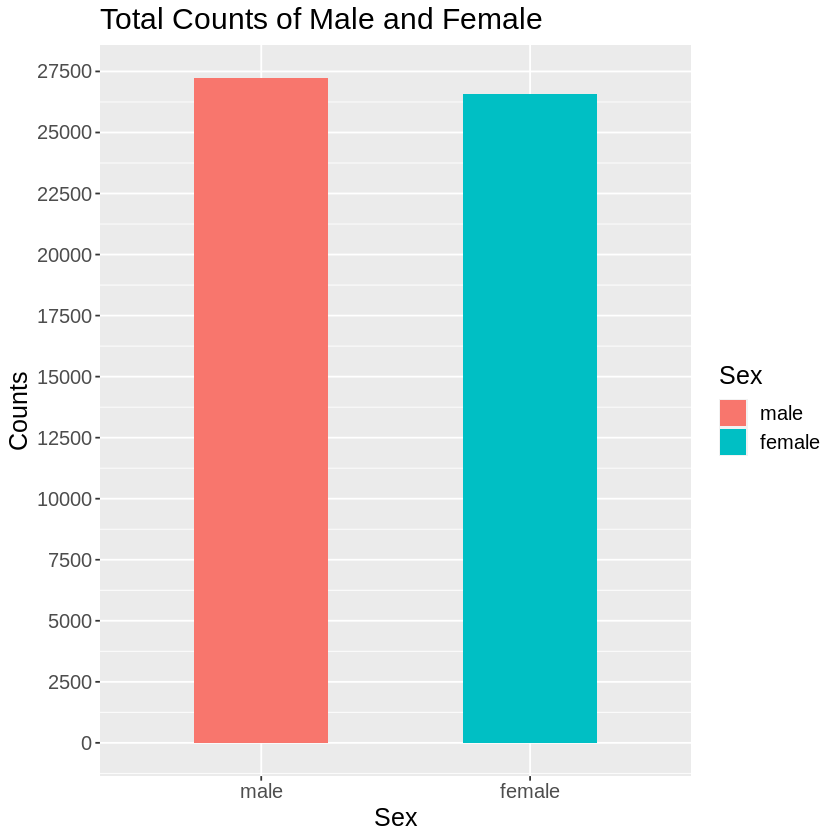

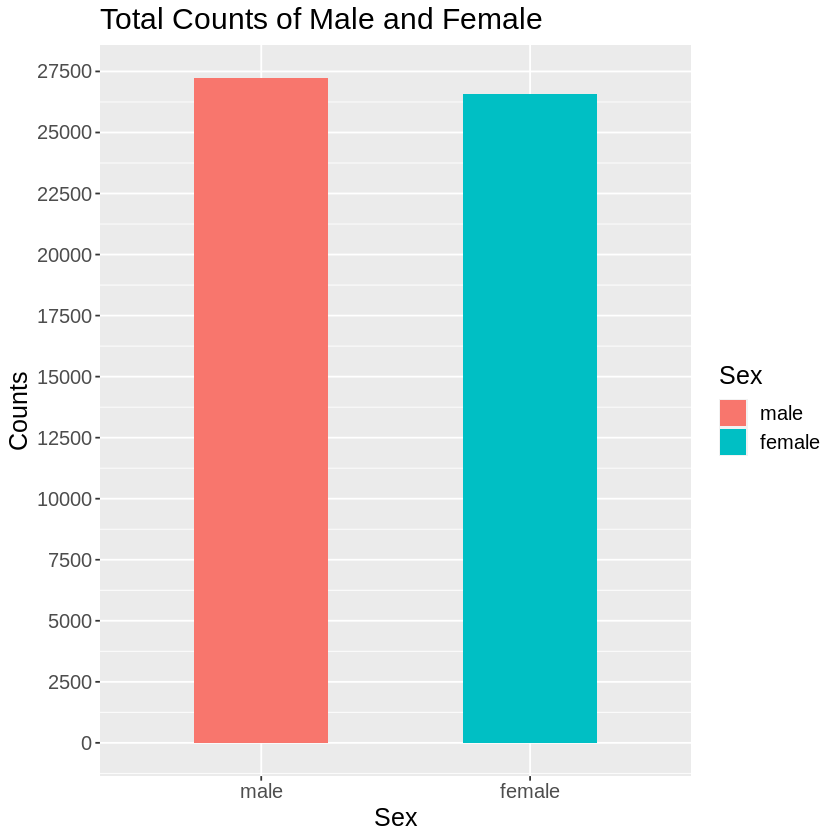

>>>>>>> remote


In [ ]:
sex_plot <- sex_summary |>
    ggplot(aes(x = sex, y = count, fill = sex)) +
    geom_bar(stat = "identity", width = 0.5) +
    scale_y_continuous(breaks=seq(0, 27500, by = 2500)) +
    labs(x = "Sex", y = "Counts", fill = "Sex") +
    theme(text = element_text(size = 15)) +
    ggtitle("Total Counts of Male and Female")
    
sex_plot

We can see that the number of man and woman in the survey are roughly equal and that the sample size for each group is quite large.

## Hourly Wage 

In [ ]:
hrwage_summary <- pay_data %>%
    group_by(sex) %>%
    summarize(median_wage = median(hrwage))
hrwage_summary

sex,median_wage
<fct>,<dbl>
male,21.63461
female,17.30769


Warning message:
“Ignoring unknown parameters: x_intercept”
Warning message:
“Removed 1186 rows containing non-finite values (stat_bin).”
ERROR while rich displaying an object: Error in `check_required_aesthetics()`:
! geom_vline requires the following missing aesthetics: xintercept

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.nu

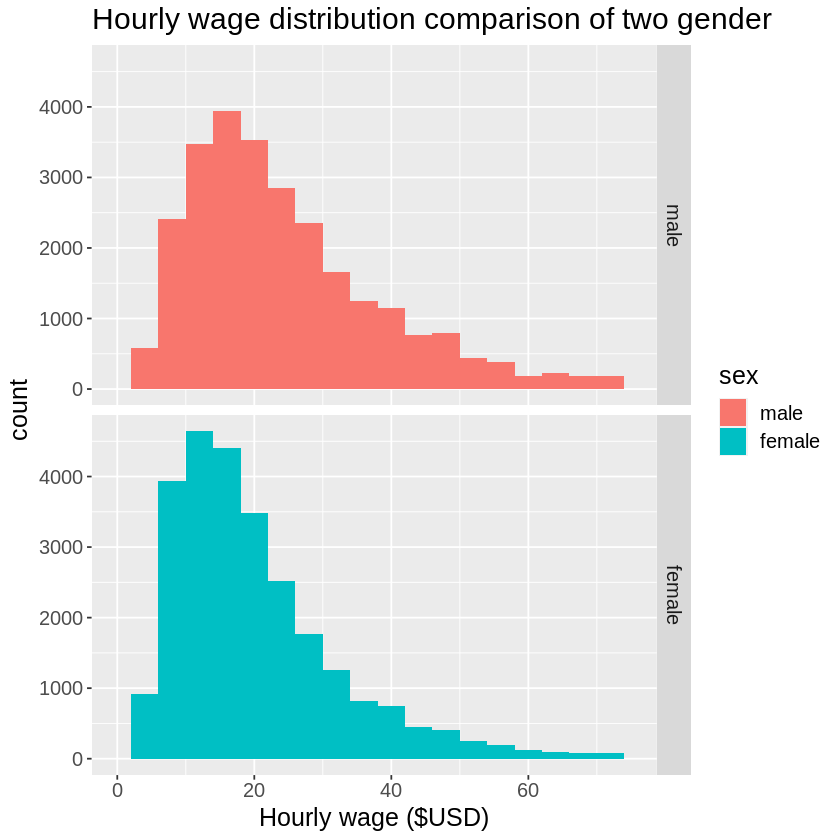

In [ ]:
hrwage_plot <- pay_data%>%ggplot() +
  geom_histogram(aes(x = hrwage), binwidth = 4) +
  facet_grid(vars(sex)) + 
  xlim(0, 75) + xlab("Hourly wage ($USD)") + 
  ggtitle("Hourly wage distribution comparison of two gender") +
  geom_vline(x_intercept = hrwage_summary$median_
  theme(text = element_text(size = 15))
hrwage_plot

# Method and Results

In [ ]:
data <- pay_data[, c("sex", "hrwage")]
head(data)

sex,hrwage
<fct>,<dbl>
male,24.91259
male,31.00000
male,21.63461
male,12.82051
male,21.25000
male,21.87500


In [ ]:
test <- t.test(hrwage ~ sex, data = data)
test


	Welch Two Sample t-test

data:  hrwage by sex
t = 5.1273, df = 27853, p-value = 2.959e-07
alternative hypothesis: true difference in means between group male and group female is not equal to 0
95 percent confidence interval:
 4.274369 9.564756
sample estimates:
  mean in group male mean in group female 
            28.84364             21.92408 


In [ ]:
set.seed(2345)
sample <- 
    data %>%
    group_by(sex) %>%
    sample_n(size = case_when(sex == "male" ~ 200,
                              sex == "female" ~ 200), replace = FALSE) %>%
    ungroup()
head(sample)

sex,hrwage
<fct>,<dbl>
male,24.55621
male,44.23077
male,19.23077
male,96.15385
male,72.11539
male,19.11765


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

<<<<<<< local


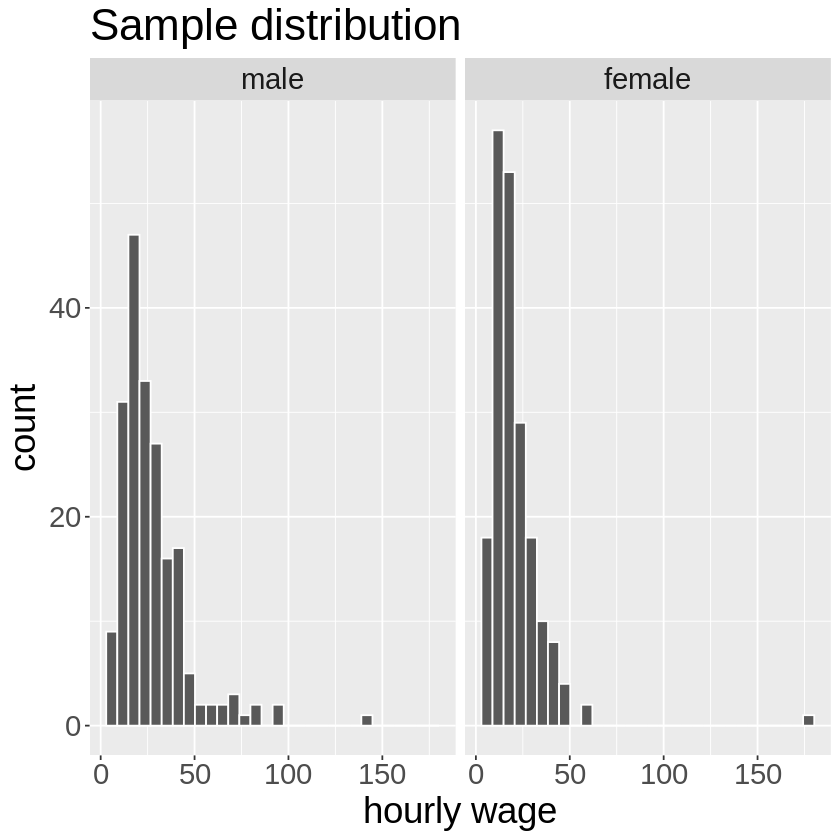

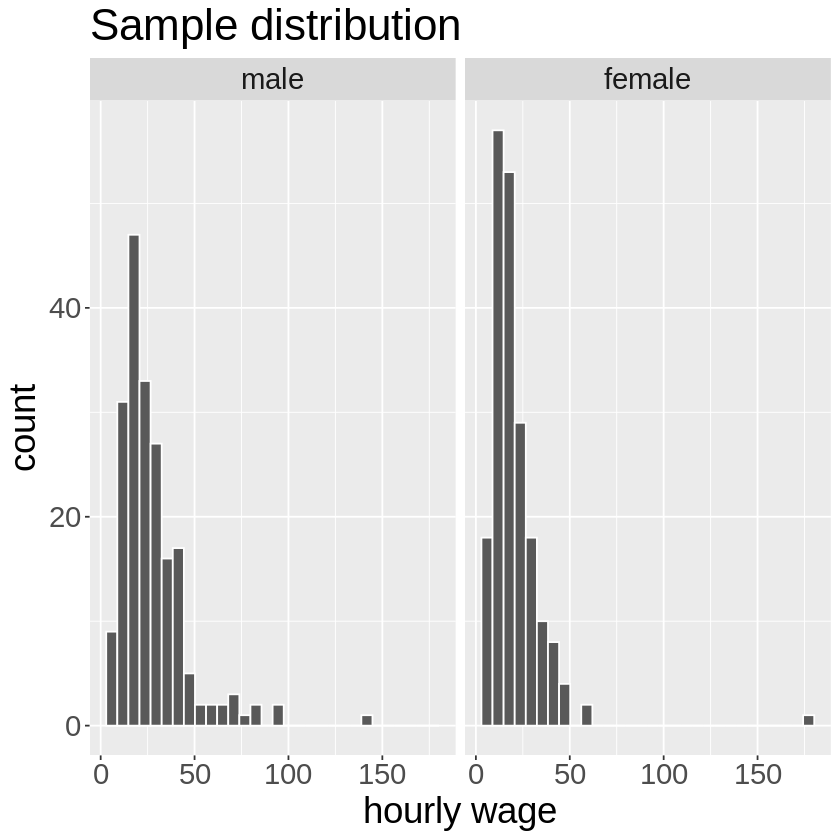

>>>>>>> remote


In [ ]:
samp_dist_plot <- 
    sample %>% 
    ggplot() + 
    geom_histogram(aes(hrwage), color = 'white') +
    facet_wrap(~ sex) + 
    theme(text = element_text(size = 22)) +
    ggtitle("Sample distribution") + 
    xlab("hourly wage")

samp_dist_plot

In [ ]:
sample_summary <- 
    sample %>%
    group_by(sex) %>%
    summarise(sample_med = median(hrwage),
             sample_std_error = sd(hrwage)/sqrt(n()))
sample_summary

sex,sample_med,sample_std_error
<fct>,<dbl>,<dbl>
male,23.07692,1.274007
female,17.54856,1.069211


In [ ]:
ci = 0.95

male_med <- sample_summary$sample_med[1]
male_var <- sample_summary$sample_std_error[1]^2
female_med <- sample_summary$sample_med[2]
female_var <- sample_summary$sample_std_error[2]^2

parking_clt_ci <- 
    tibble(lower_ci = (male_med - female_med - qnorm(1- (1-ci)/2) * sqrt(female_var + male_var)),
           upper_ci = (male_med - female_med + qnorm(1- (1-ci)/2) * sqrt(female_var + male_var)))

head(parking_clt_ci)

lower_ci,upper_ci
<dbl>,<dbl>
2.268512,8.78822


In [ ]:
t_test_summary <- sample %>%
    group_by(sex) %>%
    summarise(
        n = n(),
        x_bar = median(hrwage),
        sd = sd(hrwage)
    ) %>% 
  pivot_wider(names_from = sex, values_from = c(n, x_bar, sd)) %>% 
  mutate(
    median_diff = x_bar_male - x_bar_female
  )

t_test_summary <- t_test_summary %>%
mutate(null_std_error = sqrt((sd_male^2 / n_male) + (sd_female^2 / n_female)))

t_test_summary <- 
    t_test_summary %>% 
    mutate(p_value = 2 * pt(median_diff/null_std_error, df=n_male+n_female-1, lower.tail=FALSE))

t_test_summary

n_male,n_female,x_bar_male,x_bar_female,sd_male,sd_female,median_diff,null_std_error,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200,200,23.07692,17.54856,18.01718,15.12093,5.528366,1.663222,0.0009697577


In [ ]:
t_test <- 
    tidy(t.test(sample %>% filter(sex == "male") %>% pull(hrwage),
           sample %>% filter(sex == "female") %>% pull(hrwage)))

t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
7.065363,27.38946,20.3241,4.247999,2.70583e-05,386.3729,3.795265,10.33546,Welch Two Sample t-test,two.sided


In [20]:
#make sure to justify the size
one_sample <- pay_data |>
rep_sample_n(size = 500)

In [21]:
diff_in_medians <- one_sample |>
    specify(formula = hrwage ~ sex) |>
    hypothesize(null = "independence") |>
    generate(reps = 10000, type = "permute") |>
    calculate(stat = "diff in medians", order = c("male", "female"))

head(diff_in_medians)

replicate,stat
<int>,<dbl>
1,0.08741379
2,-0.48077011
3,-0.08741379
4,1.70940208
5,-1.44230842
6,1.70940208


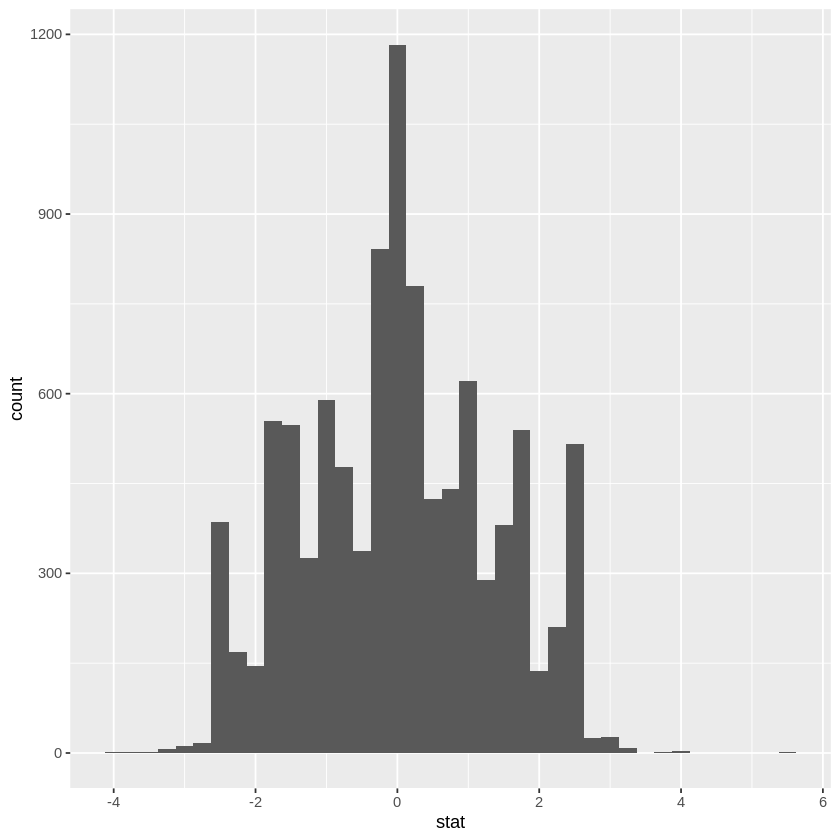

In [27]:
bootstrap_diff_in_medians <- diff_in_medians |>
    ggplot(aes(x = stat)) +
    geom_histogram(binwidth = 0.25)
bootstrap_diff_in_medians